# Circuito cuántico para autoencoder

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.circuit import Parameter, ParameterVector
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

Inicialziqamos las carácteristicas de nuestro circuito cuántico y de nuestro conjunto de datos de manera aleatoria 

In [2]:
n=6
num_layers = 1
params = np.random.random(14*(num_layers))

In [3]:
k = 10

x_train =[]
for i in range(k):
    x_train.append(np.random.random(n))
x_train[0]

array([0.58637636, 0.99707387, 0.26373708, 0.00133883, 0.16005027,
       0.99570452])

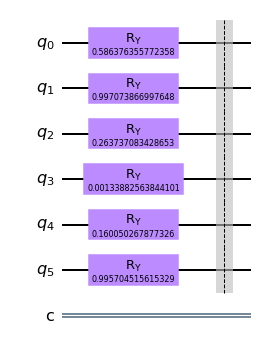

In [4]:
def input_data(n,inputs):
    inputs_parameters = ParameterVector('input', n)
    circuit = QuantumCircuit(n,1)
    for inp in range(n):
        #Appending the parameterized Ry gates using parameters from the vector constructed above
        circuit.ry(inputs_parameters[inp], inp)
    circuit.barrier()
    
    inputs_dict = {}
    i = 0
    for p in inputs_parameters:
        inputs_dict[p] = inputs[i]
        i += 1 
    circuit = circuit.assign_parameters(parameters = inputs_dict)
    return circuit
input_data(n,x_train[0]).draw()

In [5]:
def vqc(n, num_layers,params):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length
    
    
    parameters = ParameterVector('θ', 14*(num_layers))
    len_p = len(parameters)
    circuit = QuantumCircuit(n, 1)
    

    
    for layer in range(num_layers):
        for i in range(n):
            circuit.ry(parameters[(n*(layer))+i], i)
        circuit.barrier()

        circuit.cz(0,1)
        circuit.cz(0,2)
        circuit.cz(1,3)
        circuit.cz(0,4)
        circuit.cz(1,5)
        circuit.barrier()
        
        for i in range(n):
            circuit.ry(parameters[n*(layer+1)+i], i-n)
        circuit.barrier()
        
        circuit.cz(0,1)
        circuit.cz(0,3)
        circuit.cz(1,2)
        circuit.cz(0,5)
        circuit.cz(1,4)
        circuit.barrier()

        for i in range(2):
            circuit.ry(parameters[2*n*(layer+1)+i], i)
        circuit.barrier()
    
    params_dict = {}
    i = 0
    for p in parameters:
        params_dict[p] = params[i]
        i += 1
    #Assign parameters using the assign_parameters method
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit

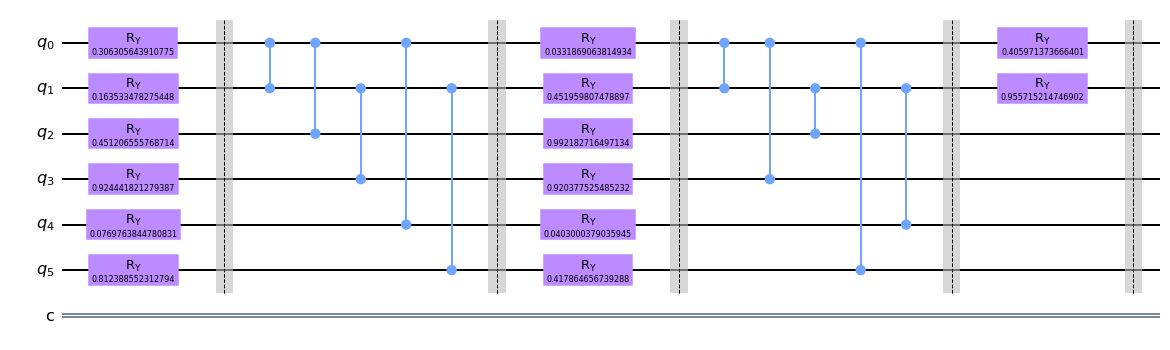

In [6]:
vqc(n,num_layers,params).draw()

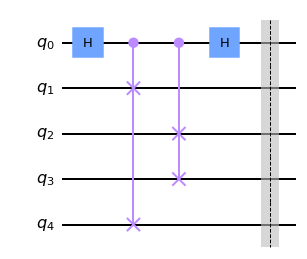

In [7]:
def swap_test(n):
    qubits_values = 2*n+1
    qc = QuantumCircuit(qubits_values)
    qc.h(0)
    for i in range(n):
        qc.cswap(0,i+1,2*n-i)
    qc.h(0)
    qc.barrier()
    return qc
swap_test(2).draw()

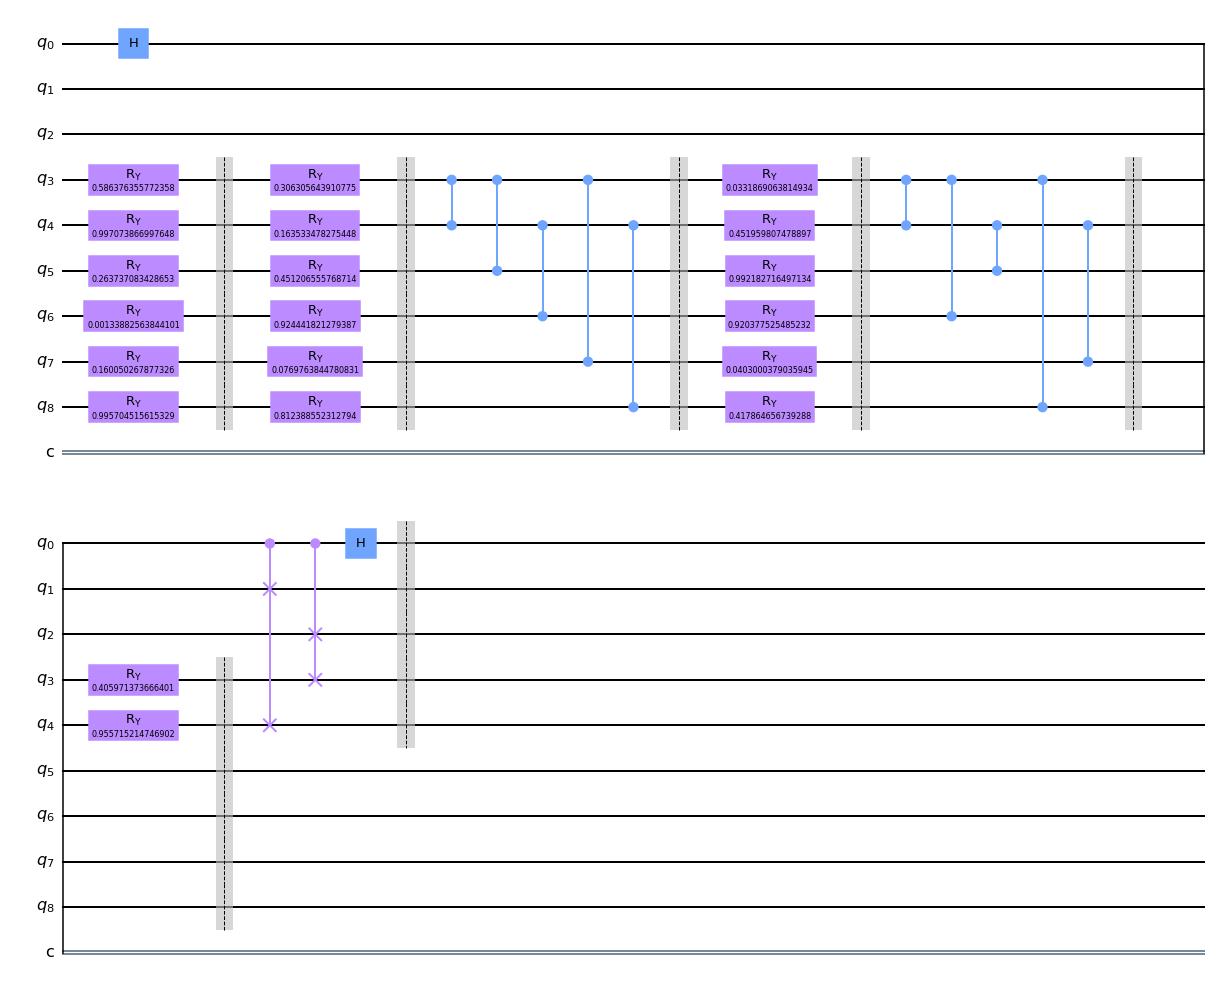

In [8]:
size_reduce = 2
circuit_init = input_data(n,x_train[0])
circuit_vqc = vqc(n,num_layers,params)
circuit_swap_test = swap_test(size_reduce)

circuit_full = QuantumCircuit(n+size_reduce+1,1)

circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
circuit_full.draw()

In [9]:
from scipy.optimize import minimize ## need the mthod minimize of scipy.optimize module

def calc_cost(circuit_value):
    diff = sum(circuit_value)       ## calculates the sum of squares 
    mod_abs = diff.real**2 + diff.imag**2   ## of mod of difference between corresponding elements 
    cost = np.sum(mod_abs)                  ## of real_value and circuit_value
    return cost                             ## returns the cost

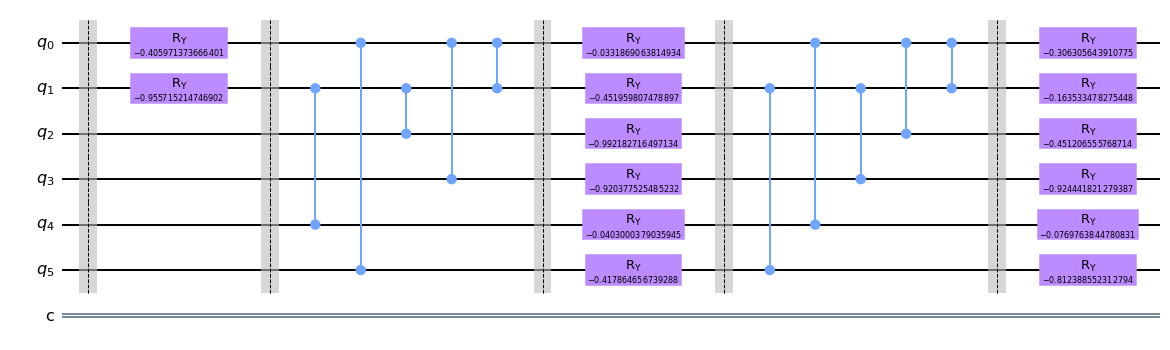

In [10]:
vqc(n,num_layers,params).inverse().draw()

## Coder 

In [11]:
def objective_function(params):
    compress = []
    for i in range(len(x_train)):
        circuit_init = input_data(n,x_train[i])
        circuit_vqc = vqc(n,num_layers,params)
        circuit_swap_test = swap_test(size_reduce)

        circuit_full = QuantumCircuit(n+size_reduce+1,1)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
        circuit_full.measure(0, 0)
        #qc.draw()
        job = execute( circuit_full, Aer.get_backend('qasm_simulator') )
        result = job.result().get_counts()
        
        try:
            compress.append(result['1']/1024)
        except:
            compress.append(0)
        cost = calc_cost(compress)
    return cost

    
minimum = minimize(objective_function, params, method='COBYLA', tol=1e-6)
params = minimum.x
print(" cost: ",objective_function(params))

 cost:  0.1495513916015625


In [40]:
def compress_result(params):
    reduce = []
    for i in range(len(x_train)):
        circuit_init = input_data(n,x_train[i])
        circuit_vqc = vqc(n,num_layers,params)

        circuit_full = QuantumCircuit(n+size_reduce+1,4)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
        len_cf = len(circuit_full)
        for i in range(n-size_reduce):
            circuit_full.measure(1+2*size_reduce+i, i)
        job = execute( circuit_full, Aer.get_backend('qasm_simulator') )
        result = job.result().get_counts()
        probs = {k: v / 1024 for k, v in result.items()}
        reduce.append(probs)
        print(probs)
        
    return reduce
        
compress_result(params)



{'1000': 0.0166015625, '0100': 0.0009765625, '1111': 0.0009765625, '1010': 0.017578125, '1101': 0.0009765625, '0101': 0.001953125, '1100': 0.0009765625, '1001': 0.1865234375, '0010': 0.0283203125, '1011': 0.2626953125, '0111': 0.001953125, '0000': 0.015625, '0011': 0.234375, '0001': 0.23046875}
{'0110': 0.0009765625, '0101': 0.00390625, '1111': 0.0078125, '1010': 0.017578125, '1011': 0.2705078125, '0010': 0.04296875, '0001': 0.0205078125, '0000': 0.0009765625, '0011': 0.595703125, '0111': 0.0244140625, '1001': 0.0146484375}
{'0010': 0.001953125, '1111': 0.0068359375, '1011': 0.169921875, '0011': 0.6708984375, '0111': 0.0517578125, '1001': 0.0087890625, '0101': 0.0126953125, '0001': 0.0771484375}
{'1000': 0.0009765625, '1110': 0.0009765625, '0110': 0.0009765625, '0100': 0.0009765625, '0101': 0.01171875, '1111': 0.0126953125, '1010': 0.0087890625, '0001': 0.1318359375, '1011': 0.119140625, '1001': 0.037109375, '0000': 0.0068359375, '0011': 0.5634765625, '0111': 0.0546875, '0010': 0.04980

[{'1000': 0.0166015625,
  '0100': 0.0009765625,
  '1111': 0.0009765625,
  '1010': 0.017578125,
  '1101': 0.0009765625,
  '0101': 0.001953125,
  '1100': 0.0009765625,
  '1001': 0.1865234375,
  '0010': 0.0283203125,
  '1011': 0.2626953125,
  '0111': 0.001953125,
  '0000': 0.015625,
  '0011': 0.234375,
  '0001': 0.23046875},
 {'0110': 0.0009765625,
  '0101': 0.00390625,
  '1111': 0.0078125,
  '1010': 0.017578125,
  '1011': 0.2705078125,
  '0010': 0.04296875,
  '0001': 0.0205078125,
  '0000': 0.0009765625,
  '0011': 0.595703125,
  '0111': 0.0244140625,
  '1001': 0.0146484375},
 {'0010': 0.001953125,
  '1111': 0.0068359375,
  '1011': 0.169921875,
  '0011': 0.6708984375,
  '0111': 0.0517578125,
  '1001': 0.0087890625,
  '0101': 0.0126953125,
  '0001': 0.0771484375},
 {'1000': 0.0009765625,
  '1110': 0.0009765625,
  '0110': 0.0009765625,
  '0100': 0.0009765625,
  '0101': 0.01171875,
  '1111': 0.0126953125,
  '1010': 0.0087890625,
  '0001': 0.1318359375,
  '1011': 0.119140625,
  '1001': 0.0371